In [4]:
!pip install python-louvain nxviz

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
from community import community_louvain
import networkx.algorithms.community as nx_comm
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
from scipy import stats
from collections import Counter, defaultdict
import warnings
import ast
warnings.filterwarnings('ignore')

## Preprocessing

Данные были взяты из канала, посвященному видеоигре жанра military simulator, на платформе Discord. . Исходный датасет представляет собой историю сообщений, выгруженную в формате JSON/CSV, содержащую ID пользователей, упоминания и информацию о том, является ли сообщение ответом (reply) на другое сообщение. Объем датасета ~7000 строк. Были собраны взаимодействия участников канала (юнита в видеоигре) из открытого чата за последний месяц.

In [6]:
df = pd.read_csv("messages.csv", dtype={
    'message_id': str,
    'author_id': str,
    'reply_to_author': str
})
replies = df.dropna(subset=['reply_to_author'])

In [7]:
df.head()

,message_id,author_id,author_name,timestamp,reply_to_author,reply_to_author_name,mentions,mention_names,content_length
0,1452288117439594527,253822338636840961,nightmarewarrior,2025-12-21T13:14:29.406000+00:00,776722014119264286,0_gips_0,[776722014119264286],['0_gips_0'],15
1,1452282622129733683,300254528039550986,thesanctifiedone,2025-12-21T12:52:39.222000+00:00,NaN,NaN,[],[],12
2,1452278692226138243,776722014119264286,0_gips_0,2025-12-21T12:37:02.260000+00:00,NaN,NaN,[1452242654807982120],['reSearcher#7814'],63
3,1452009640597524693,492704287311527947,alexseytabako,2025-12-20T18:47:55.353000+00:00,NaN,NaN,[],[],48
4,1452009560943493194,492704287311527947,alexseytabako,2025-12-20T18:47:36.362000+00:00,NaN,NaN,[],[],30


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6833 entries, 0 to 6832
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   message_id            6833 non-null   object
 1   author_id             6833 non-null   object
 2   author_name           6833 non-null   object
 3   timestamp             6833 non-null   object
 4   reply_to_author       1997 non-null   object
 5   reply_to_author_name  1997 non-null   object
 6   mentions              6833 non-null   object
 7   mention_names         6833 non-null   object
 8   content_length        6833 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 480.6+ KB


С учетом специфики взаимодействия, в ходе ручного анализа случайной выборки данных, было принято решение использовать в качестве граней только ответы на сообщения, опуская упоминания во избежание перекоса данных (включения спам-сообщений с упоминаниями в выборку).

In [9]:
edges_data = replies.groupby(['author_id', 'reply_to_author']).size().reset_index(name='weight')
# никнейм может быть не уникальным, поэтому был взять id и вдальнейшем сопоставлен с никнеймом
G = nx.DiGraph()

for _, row in edges_data.iterrows():
    G.add_edge(row['author_id'], row['reply_to_author'], weight=row['weight'])

author_map = dict(zip(df['author_id'], df['author_name']))
nx.set_node_attributes(G, author_map, 'name')

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 169, Edges: 913


# Свойства:

**Узлов** (169)


*   name (Никнейм): Отображаемое имя пользователя (без тега #0000).
*   id (Идентификатор): Уникальный Discord Snowflake ID. Он является ключом узла.

**Граней**(913)

*   weight (Вес): интенсивность общения. Если один пользователь ответил другому 10 раз, вес ребра будет равен 10. На визуализации это отражается толщиной линии.
*   Направленность: «от кого» и «кому». Показывается стрелочкой.







In [10]:
nodes_list = list(G.nodes())

node_names = [author_map.get(node_id, f"Unknown ID: {node_id}") for node_id in nodes_list]

node_names.sort()

print(f"Список всех узлов ({len(node_names)} шт.)")
for name in node_names:
    print(name)

if len(nodes_list) == len(set(nodes_list)):
    print("\n✅")
else:
    print("\n Есть дубликаты ID в списке узлов.")

Список всех узлов (169 шт.)
._neon
.aden_skirata_n_12
.danetxyi
.fortis.fortuna.adiuvat.
.quantron
.rommele
.sayrezz
0_gips_0
0lohowhina0
1xxxx1
34_jack_90
442doc
6238
6kegz
777westheimer777
888888881
Deleted User#0000
Hesh Junior#8880
JuniperBot#6999
__sedoy
_brims
_noxproject_
_nseven
_sovok
_stinger._
_teklin_
absurdd911
afonya_nafanya
ahtoxa0
akexander5
alex_nalsan
alexseytabako
alko_k0t.
barbariksss
betta002
bidlonalegende
bigflextime
bluehairedmenace
blyad1310
bolshevik_1917.
bronya3872
burlak
chermik.
chlor0741
clonecg
como_4ek
copyline
csrmn
ctarkit
darik4450
darkminikin
darth_crusader
daytona7202
deasmond.
dess_daison
diolva
do3qp
docent_vudi
dshamsut
dustsans4832
englishman3788
eugeniy85
fantik5532
filya4090
firstnafanya
folez.
forbl
fufl0
ghostdi8133
hohitos
holynikolas
im_genius_shiro_oleg
ivangos
izumi_just
joker1816
kay_straus
kee.keema
kerni_misha
key5832
kolbasshelby
kosiposha1551
krieg1313
l1_mon
lancelotxd
layout1
liss144
lucas5367
mason731
mayron_gg
mblpk
medvedvasa


Мы удаляем ботов и удаленных пользователей - боты заведомо будут центром взаимодействия, поскольку отвечают на сообщения активных пользователей стикерами независимо от того, общались ли с ними или нет, вызывая неестественное увеличение в активности. Удаленные пользователи все отображаются одинаково, независимо от того, кому принадлежал аккаунт.

In [11]:
names_to_remove = ["Deleted User#0000", "JuniperBot#6999", "Hesh Junior#8880"]

ids_to_remove = [node_id for node_id, name in author_map.items() if name in names_to_remove]
G.remove_nodes_from(ids_to_remove)

# удаляем изолированные узлы (у кого 0 связей после удаления ботов)
G.remove_nodes_from(list(nx.isolates(G)))

print(f"Итоговая сеть для анализа: {G.number_of_nodes()} узлов.")

Итоговая сеть для анализа: 164 узлов.


## После очистки:

In [35]:
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 164, Edges: 856


In [12]:
U = G.to_undirected()
partition = community_louvain.best_partition(U, weight='weight')
pagerank = nx.pagerank(G, weight='weight')

#communities = {}
#for node, p in partition.items():
#    communities.setdefault(p, []).append(node)

## Характеристика сети

Directed (Ориентированная): Связи имеют направление (кто кому ответил). Это позволяет вычислять такие метрики, как In-degree (популярность) и Out-degree (активность), а также использовать алгоритмы PageRank и HITS.

Weighted (Взвешенная): Каждое ребро имеет вес (weight), равный количеству ответов между пользователями. Это позволяет отличить случайное разовое взаимодействие от регулярного общения.

Homogeneous (Однородная): Все узлы представляют объекты одного типа (пользователей), а все грани — один тип действия (ответы).

Порог для грани: 2 взаимодествия

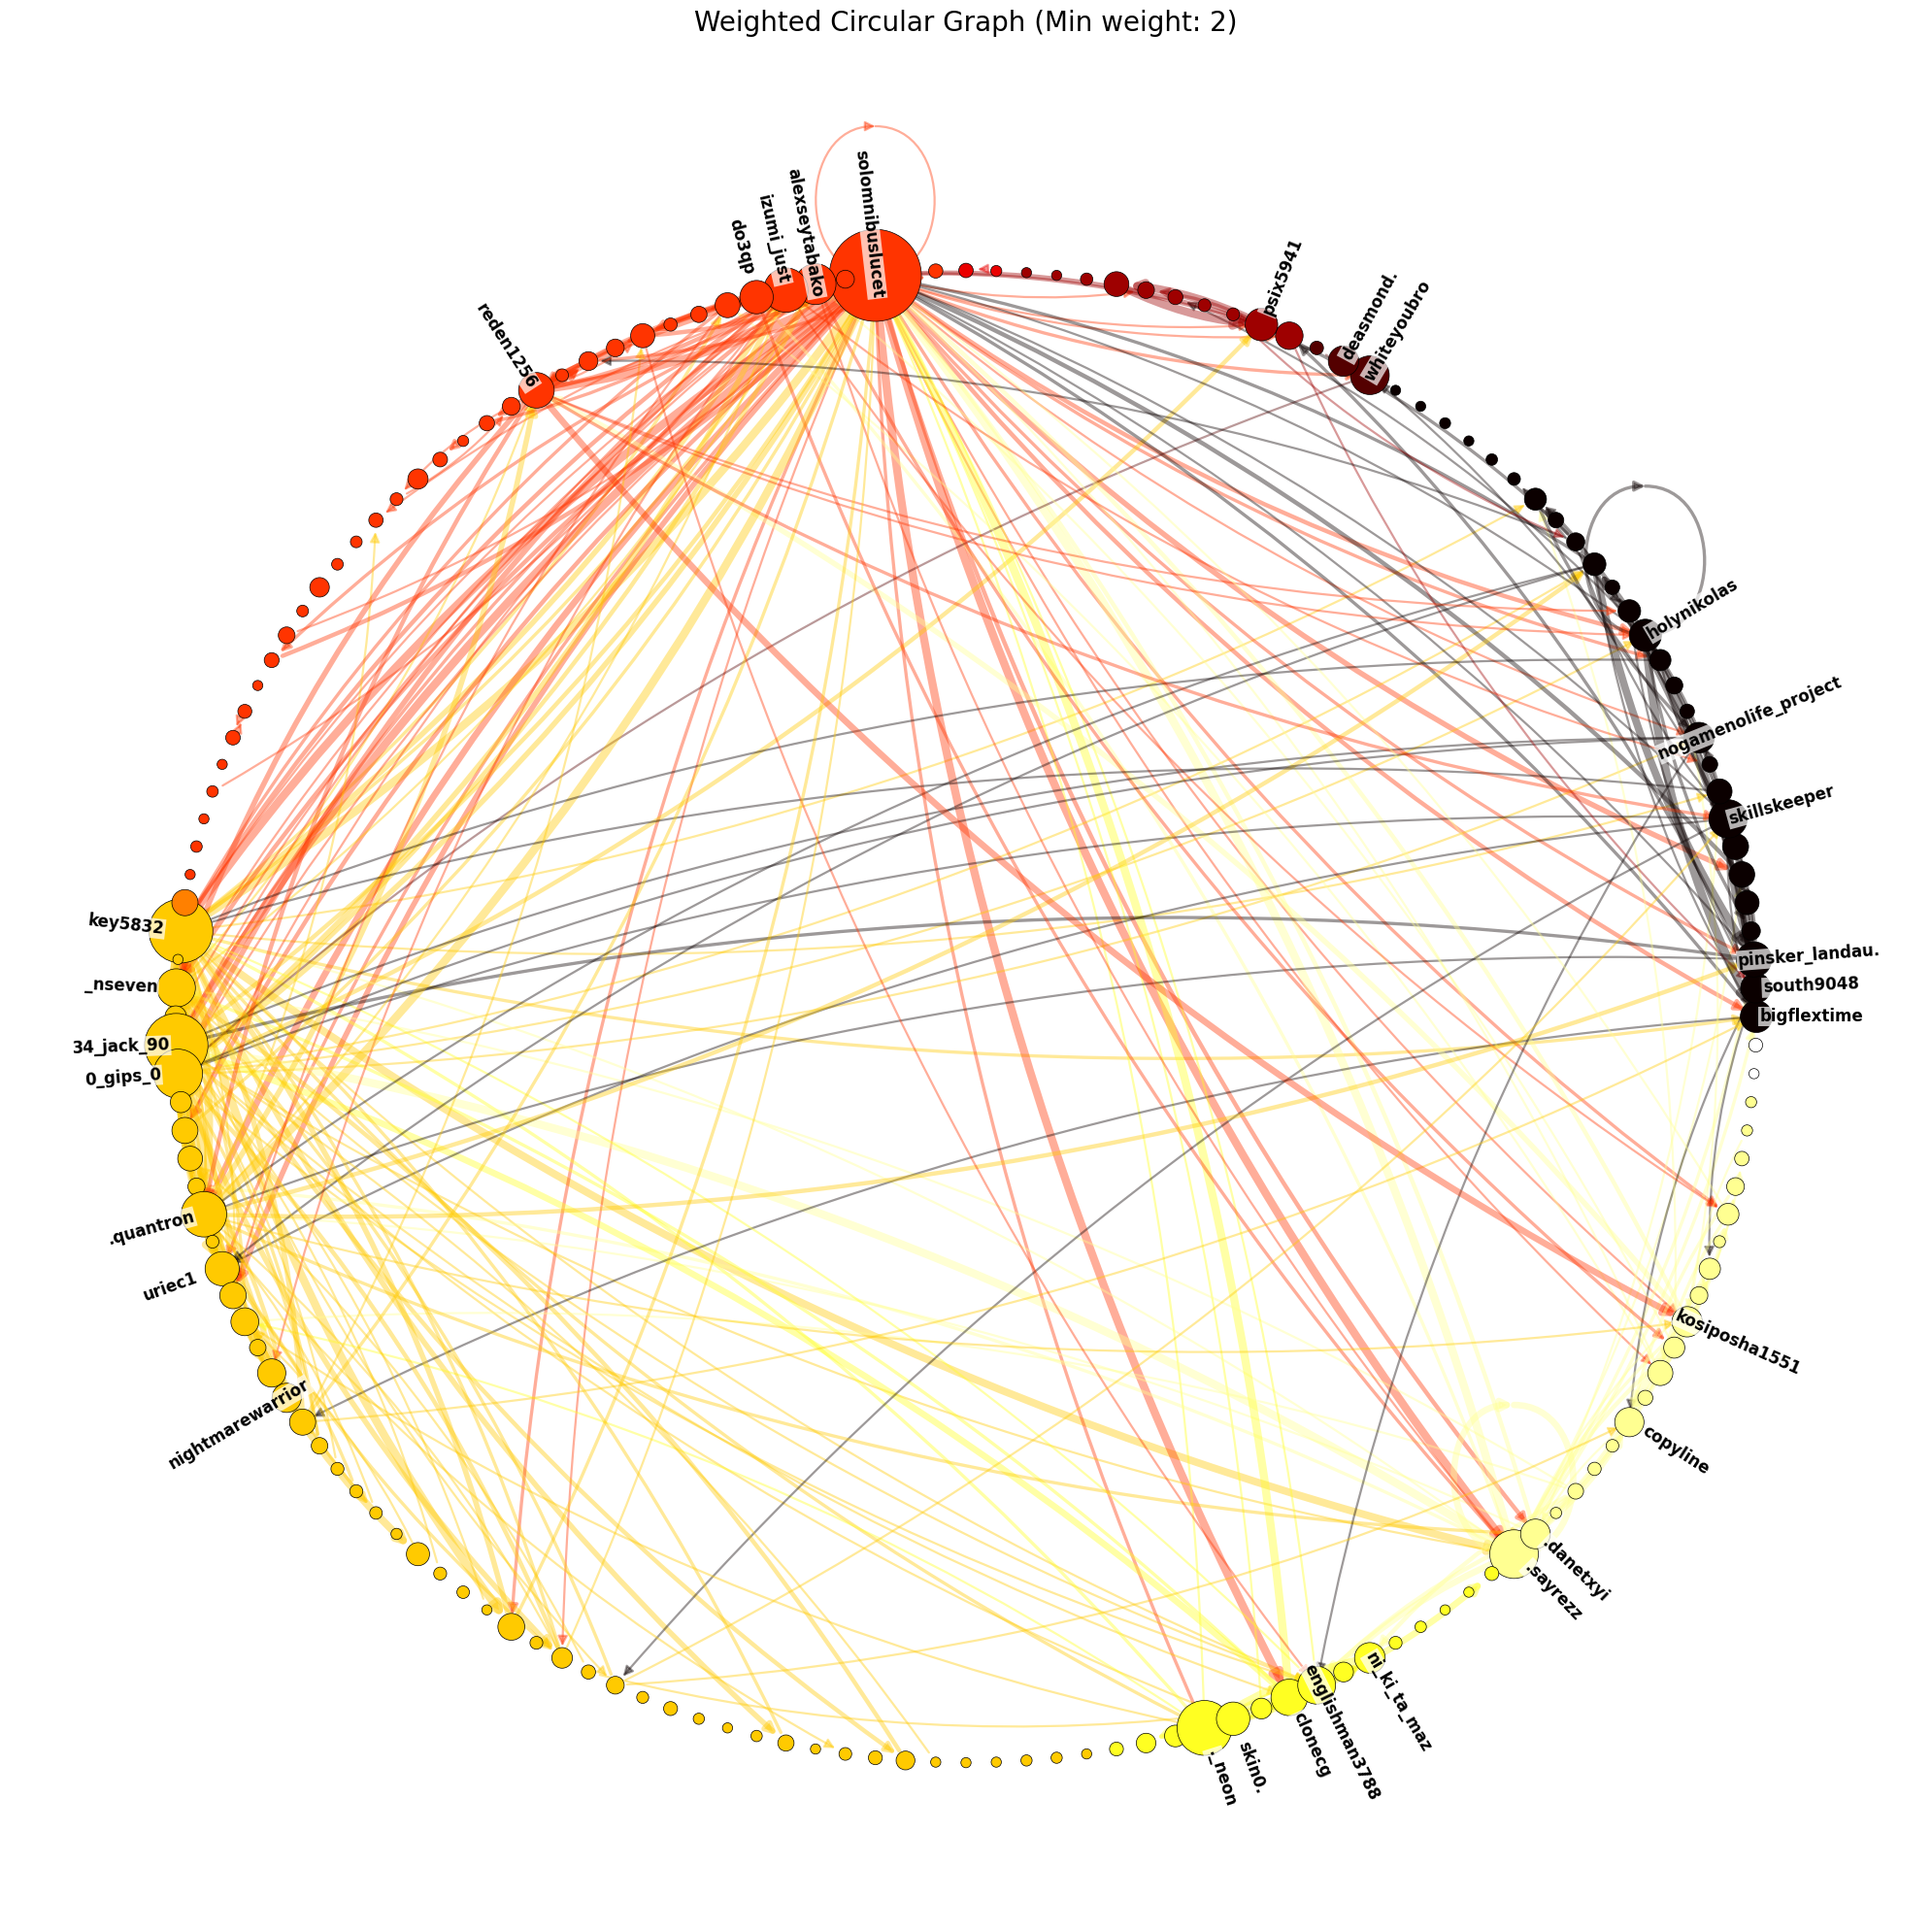

In [13]:
threshold = 2
render_edges = []
edge_widths = []
edge_colors = []
cmap = plt.cm.hot

max_w = max([d['weight'] for u, v, d in G.edges(data=True)]) if G.edges() else 1

for u, v, data in G.edges(data=True):
    weight = data['weight']
    if weight >= threshold:
        render_edges.append((u, v))
        edge_widths.append(min(weight * 0.8, 6))

        color_val = partition[u] / (max(partition.values()) if partition.values() else 1)
        edge_colors.append(cmap(color_val))

sorted_nodes = sorted(G.nodes(), key=lambda n: partition[n])
pos = {}
angle_step = 2 * np.pi / len(sorted_nodes)
for i, node in enumerate(sorted_nodes):
    angle = i * angle_step
    pos[node] = np.array([np.cos(angle), np.sin(angle)])

plt.figure(figsize=(20, 20), facecolor='white')

nx.draw_networkx_edges(
    G, pos,
    edgelist=render_edges,
    width=edge_widths,
    edge_color=edge_colors,
    alpha=0.4,
    connectionstyle="arc3,rad=0.1",
    arrowsize=15,
    arrowstyle='-|>'
)

node_sizes = [pagerank[n] * 50000 for n in G.nodes()]
node_colors = [partition[n] for n in G.nodes()]

nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=cmap,
    edgecolors='black',
    linewidths=0.5
)

# топ-30 по PageRank
top_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:30]
for node in top_nodes:
    x, y = pos[node]
    name = G.nodes[node].get('name', node)
    label = str(name).split('#')[0]

    angle = np.arctan2(y, x) * 180 / np.pi
    rotation = angle if abs(angle) < 90 else angle + 180

    plt.text(
        x * 1.07, y * 1.07,
        s=label,
        fontsize=12, fontweight='bold',
        ha='center', va='center',
        rotation=rotation,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

plt.title(f"Weighted Circular Graph (Min weight: {threshold})", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()

## Degree Distribution

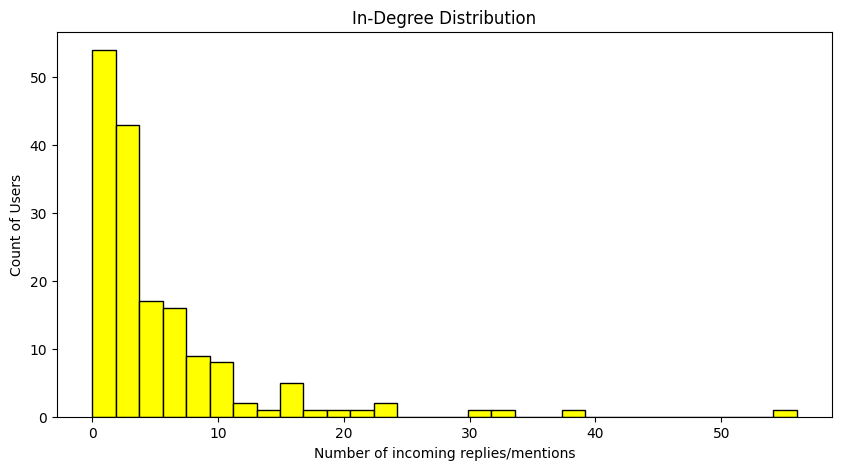

In [14]:
in_degrees = [d for n, d in G.in_degree()]

plt.figure(figsize=(10, 5))
plt.hist(in_degrees, bins=30, color='yellow', edgecolor='black')
plt.title("In-Degree Distribution")
plt.xlabel("Number of incoming replies/mentions")
plt.ylabel("Count of Users")
plt.show()

Распределение степеней в исследуемой сети не является нормальным и соответствует степенному закону. Наличие небольшого числа хабов с высокой степенью (~55) при большом количестве малоактивных узлов подтверждает безмасштабную природу сети и объясняет её высокую централизацию вокруг лидеров мнений

In [15]:
def random_from_real(graph):
    """
    Создает случайный граф Эрдеша-Реньи с тем же числом узлов
    и той же средней степенью, что и у входного графа.
    """
    n = graph.number_of_nodes()
    degrees = dict(graph.degree())
    avg_deg = sum(degrees.values()) / n

    p = avg_deg / (n - 1)

    G_rand = nx.gnp_random_graph(n, p, seed=42)
    return G_rand

In [16]:
def get_pdf(graph):
    degree_hist = np.array(nx.degree_histogram(graph))
    idx = np.argwhere(degree_hist > 0).flatten()
    probs = degree_hist[idx] / graph.number_of_nodes()
    return idx, probs

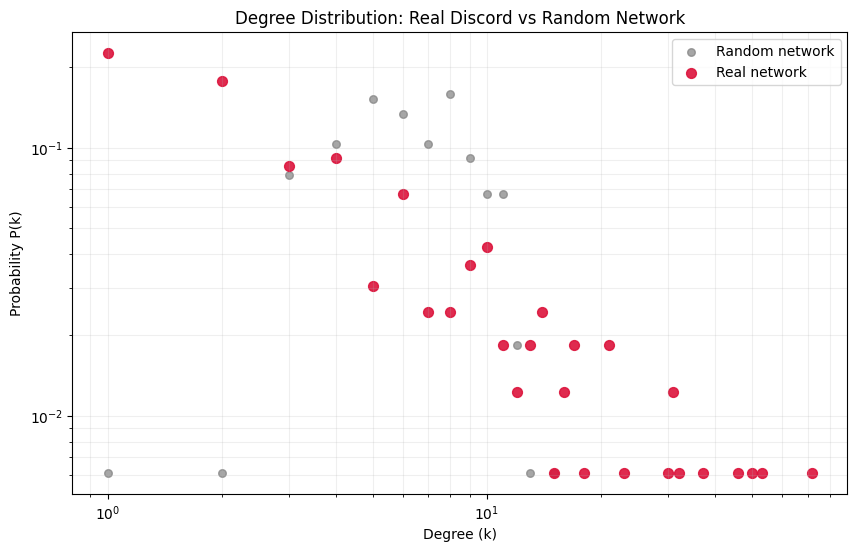

Nodes: 164
Real Avg Degree: 7.37
Random Avg Degree: 6.85


In [17]:
real_net = U
random_net = random_from_real(real_net)

plt.figure(figsize=(10, 6))

idx_rand, probs_rand = get_pdf(random_net)
plt.scatter(idx_rand, probs_rand, s=30, alpha=0.7, label='Random network', color='gray')

idx_real, probs_real = get_pdf(real_net)
plt.scatter(idx_real, probs_real, s=50, alpha=0.9, label='Real network', color='crimson')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.xlabel('Degree (k)')
plt.ylabel('Probability P(k)')
plt.title('Degree Distribution: Real Discord vs Random Network')
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

print(f"Nodes: {real_net.number_of_nodes()}")
print(f"Real Avg Degree: {np.mean(list(dict(real_net.degree()).values())):.2f}")
print(f"Random Avg Degree: {np.mean(list(dict(random_net.degree()).values())):.2f}")

In [18]:
def get_metrics(graph):
    undirected = graph.to_undirected()

    largest_cc = max(nx.connected_components(undirected), key=len)
    sub = undirected.subgraph(largest_cc)

    avg_path = nx.average_shortest_path_length(sub)
    avg_clust = nx.average_clustering(sub)
    return avg_path, avg_clust, len(largest_cc)


In [19]:
# реальная сеть

path_real, clust_real, size_real = get_metrics(G)
print(f"Real Network (Largest Component: {size_real} nodes)")
print(f"Avg Shortest Path: {path_real:.2f}")
print(f"Clustering Coeff: {clust_real:.4f}")

Real Network (Largest Component: 161 nodes)
Avg Shortest Path: 2.57
Clustering Coeff: 0.3395


In [20]:
# ER
n = G.number_of_nodes()
p = nx.density(G)
er_graph = nx.erdos_renyi_graph(n, p)

path_er, clust_er, size_er = get_metrics(er_graph)
print(f"Random Network (ER) (Largest Component: {size_er} nodes)")
print(f"Avg Shortest Path: {path_er:.2f}")
print(f"Clustering Coeff: {clust_er:.4f}")

Random Network (ER) (Largest Component: 163 nodes)
Avg Shortest Path: 3.40
Clustering Coeff: 0.0202


Сравнение с моделью Эрдеша-Реньи позволило подтвердить три ключевых свойства исследуемого Discord-сообщества:

Социальная сплоченность: Коэффициент кластеризации в реальной сети почти в 10 раз выше, чем в случайной. Это доказывает, что общение происходит не между случайными парами пользователей, а внутри устойчивых групп (кликов), где друзья друзей активно взаимодействуют друг с другом.

Эффективность коммуникации: Несмотря на наличие кластеров, средний путь между любыми двумя пользователями составляет всего 2.57 шага. Это сопоставимо со случайной сетью и подтверждает классический эффект «тесного мира».

Иерархичность: Распределение степеней узлов (Degree Distribution) в логарифмическом масштабе наглядно демонстрирует наличие хабов. В то время как в случайной сети вероятность появления узла с 55 связями практически равна нулю, в нашей сети такие «супер-узлы» играют роль главных коммуникационных мостов.

## Structural analysis

Высокий коэффициент кластеризации (0.33) в сочетании с коротким средним путем (2.56) соответствует модели Уоттса-Строгаца. При этом распределение степеней (In-Degree Distribution) наглядно демонстрирует наличие узлов-хабов, что характерно для безмасштабных сетей Барабаши-Альберт. В сравнении со случайным графом Эрдеша-Реньи, реальная сеть демонстрирует в 13 раз большую связность локальных сообществ

In [21]:
def get_names(centrality_dict, graph):
    """Сортирует, берет топ-5 и заменяет ID на имя пользователя"""
    sorted_items = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)

    formatted_list = []
    for node_id, value in sorted_items:
        raw_name = graph.nodes[node_id].get('name', node_id)
        clean_name = str(raw_name).split('#')[0]
        formatted_list.append(f"{clean_name} ({value:.3f})")

    return formatted_list

In [22]:
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigen = nx.eigenvector_centrality(G, weight='weight')

data = {
    "Degree (Популярность)": get_names(degree, G),
    "Betweenness (Мосты)": get_names(betweenness, G),
    "Closeness (Близость)": get_names(closeness, G),
    "PageRank": get_names(pagerank, G),
    "Eigenvector Centrality": get_names(eigen, G)
}

df_centrality = pd.DataFrame(data)

df_centrality.head()

,Degree (Популярность),Betweenness (Мосты),Closeness (Близость),PageRank,Eigenvector Centrality
0,solomnibuslucet (0.724),solomnibuslucet (0.237),solomnibuslucet (0.501),solomnibuslucet (0.093),solomnibuslucet (0.584)
1,0_gips_0 (0.448),34_jack_90 (0.105),34_jack_90 (0.464),key5832 (0.045),key5832 (0.344)
2,34_jack_90 (0.429),0_gips_0 (0.099),key5832 (0.446),34_jack_90 (0.044),.sayrezz (0.336)
3,key5832 (0.417),key5832 (0.095),0_gips_0 (0.433),._neon (0.033),34_jack_90 (0.297)
4,.sayrezz (0.337),izumi_just (0.067),izumi_just (0.423),0_gips_0 (0.027),alexseytabako (0.182)


Пользователь **solomnibuslucet** является абсолютным «хабом» данной сети, занимая первое место по всем показателям. Его высокая степень (Degree=0.724) означает, что он напрямую взаимодействует с большинством участников. То, что он также лидирует по Betweenness, подтверждает: он является главным «контроллером» информационных потоков — без него сеть могла бы распасться на изолированные группы. Это логично - он является связующим звеном между каналом (юнитом) и основным сообществом.

Особого внимания заслуживает **34_jack_90**. Несмотря на 3-е место по популярности, он занимает 2-е место по Betweenness и Closeness. Это характеризует его как ключевого посредника («брокера»), который связывает разные сообщества внутри сети и обеспечивает высокую скорость распространения информации. Это логично - он занимает позицию командира в юните.

Узел **key5832** выделяется высоким показателем PageRank (2-е место). Это говорит о том, что хотя у него может быть меньше связей, чем у других «топов», он связан с наиболее авторитетными участниками. В контексте социальных сетей это часто указывает на роль признанного эксперта или лидера мнений внутри узкого круга элиты. Поскольку он является  одним из наиболее долго находящихся в юните участником, он общается со всеми ключевыми участниками.

Анализ Eigenvector Centrality выявил ядро наиболее влиятельных участников. В отличие от PageRank, который учитывает общую популярность, Eigenvector подчеркнул связи между самими лидерами. Высокое совпадение топов по PageRank и Eigenvector в моей сети говорит о том, что лидеры мнений не только популярны среди масс, но и плотно взаимодействуют друг с другом, образуя устойчивое управленческое ядро сервера, а также выявляя "любимцев" сообщества.

Высокие значения Closeness Centrality (все топ-участники имеют показатель выше 0.4) коррелируют с предыдущими выводами о том, что сеть является «миром тесных связей» (Small-world). Любая информация от ключевых узлов достигает периферии за минимальное количество шагов.

# Вывод

Анализ центральностей показал, что сеть имеет высокоцентрализованную структуру с выраженным ядром из 4-5 человек. Такая структура эффективна для быстрой трансляции идей, но уязвима к удалению ключевых узлов (особенно лидера), так как на них держится большая часть связности графа.

In [23]:
# Расчет HITS

hubs, authorities = nx.hits(G, max_iter=100, normalized=True)

print("Кому больше всех отвечают")
top_auth = sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:5]
for node_id, score in top_auth:
    name = G.nodes[node_id].get('name', node_id).split('#')[0]
    print(f"{name}: {score:.4f}")

print("\nСамые активные")
top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:5]
for node_id, score in top_hubs:
    name = G.nodes[node_id].get('name', node_id).split('#')[0]
    print(f"{name}: {score:.4f}")

Кому больше всех отвечают
solomnibuslucet: 0.1185
34_jack_90: 0.0573
key5832: 0.0546
.sayrezz: 0.0535
0_gips_0: 0.0293

Самые активные
solomnibuslucet: 0.0933
key5832: 0.0902
.sayrezz: 0.0668
.quantron: 0.0637
izumi_just: 0.0391


Анализ алгоритма HITS выявил наличие выраженного ядра лидеров. Пользователь solomnibuslucet сочетает в себе роли главного Авторитета и ведущего Хаба, что делает его ключевой фигурой, консолидирующей сообщество. Стоит отметить, что отчасти это происходит засчет наиболее частого онлайна пользователя по сравнению с другими лидерами.

Высокие показатели Hub score у таких участников, как key5832 и .sayrezz, свидетельствуют о том, что структура сети поддерживается за счет их активного взаимодействия с лидерами мнений.

Наличие в топе Authorities пользователей, не входящих в топ Hubs (например, 34_jack_90), указывает на функциональное разделение ролей: в сети есть как "генераторы контента" (чистые авторитеты), так и "связующие звенья" (активные собеседники), что характерно для развитых социальных систем в Discord

In [24]:
degree_assort = nx.degree_assortativity_coefficient(G)

print(f"Degree Assortativity Coefficient: {degree_assort:.4f}")

Degree Assortativity Coefficient: -0.2271


Сеть является дисассортативной. Это часто встречается в чатах, где есть центральная фигура (администратор или бот, которо), которая отвечает на вопросы множества новичков. В такой структуре узлы с высокой степенью (хабы) связаны с огромным количеством узлов с низкой степенью, что делает сеть похожей на радиальную структуру (звезду)

# Community detection

In [25]:
louvain_communities = {}
for node, comm_id in partition.items():
    louvain_communities.setdefault(comm_id, set()).add(node)
mod_louvain = community.modularity(U, list(louvain_communities.values()), weight='weight')
print(f"Exact Modularity (Louvain): {mod_louvain:.4f}")

Exact Modularity (Louvain): 0.3286


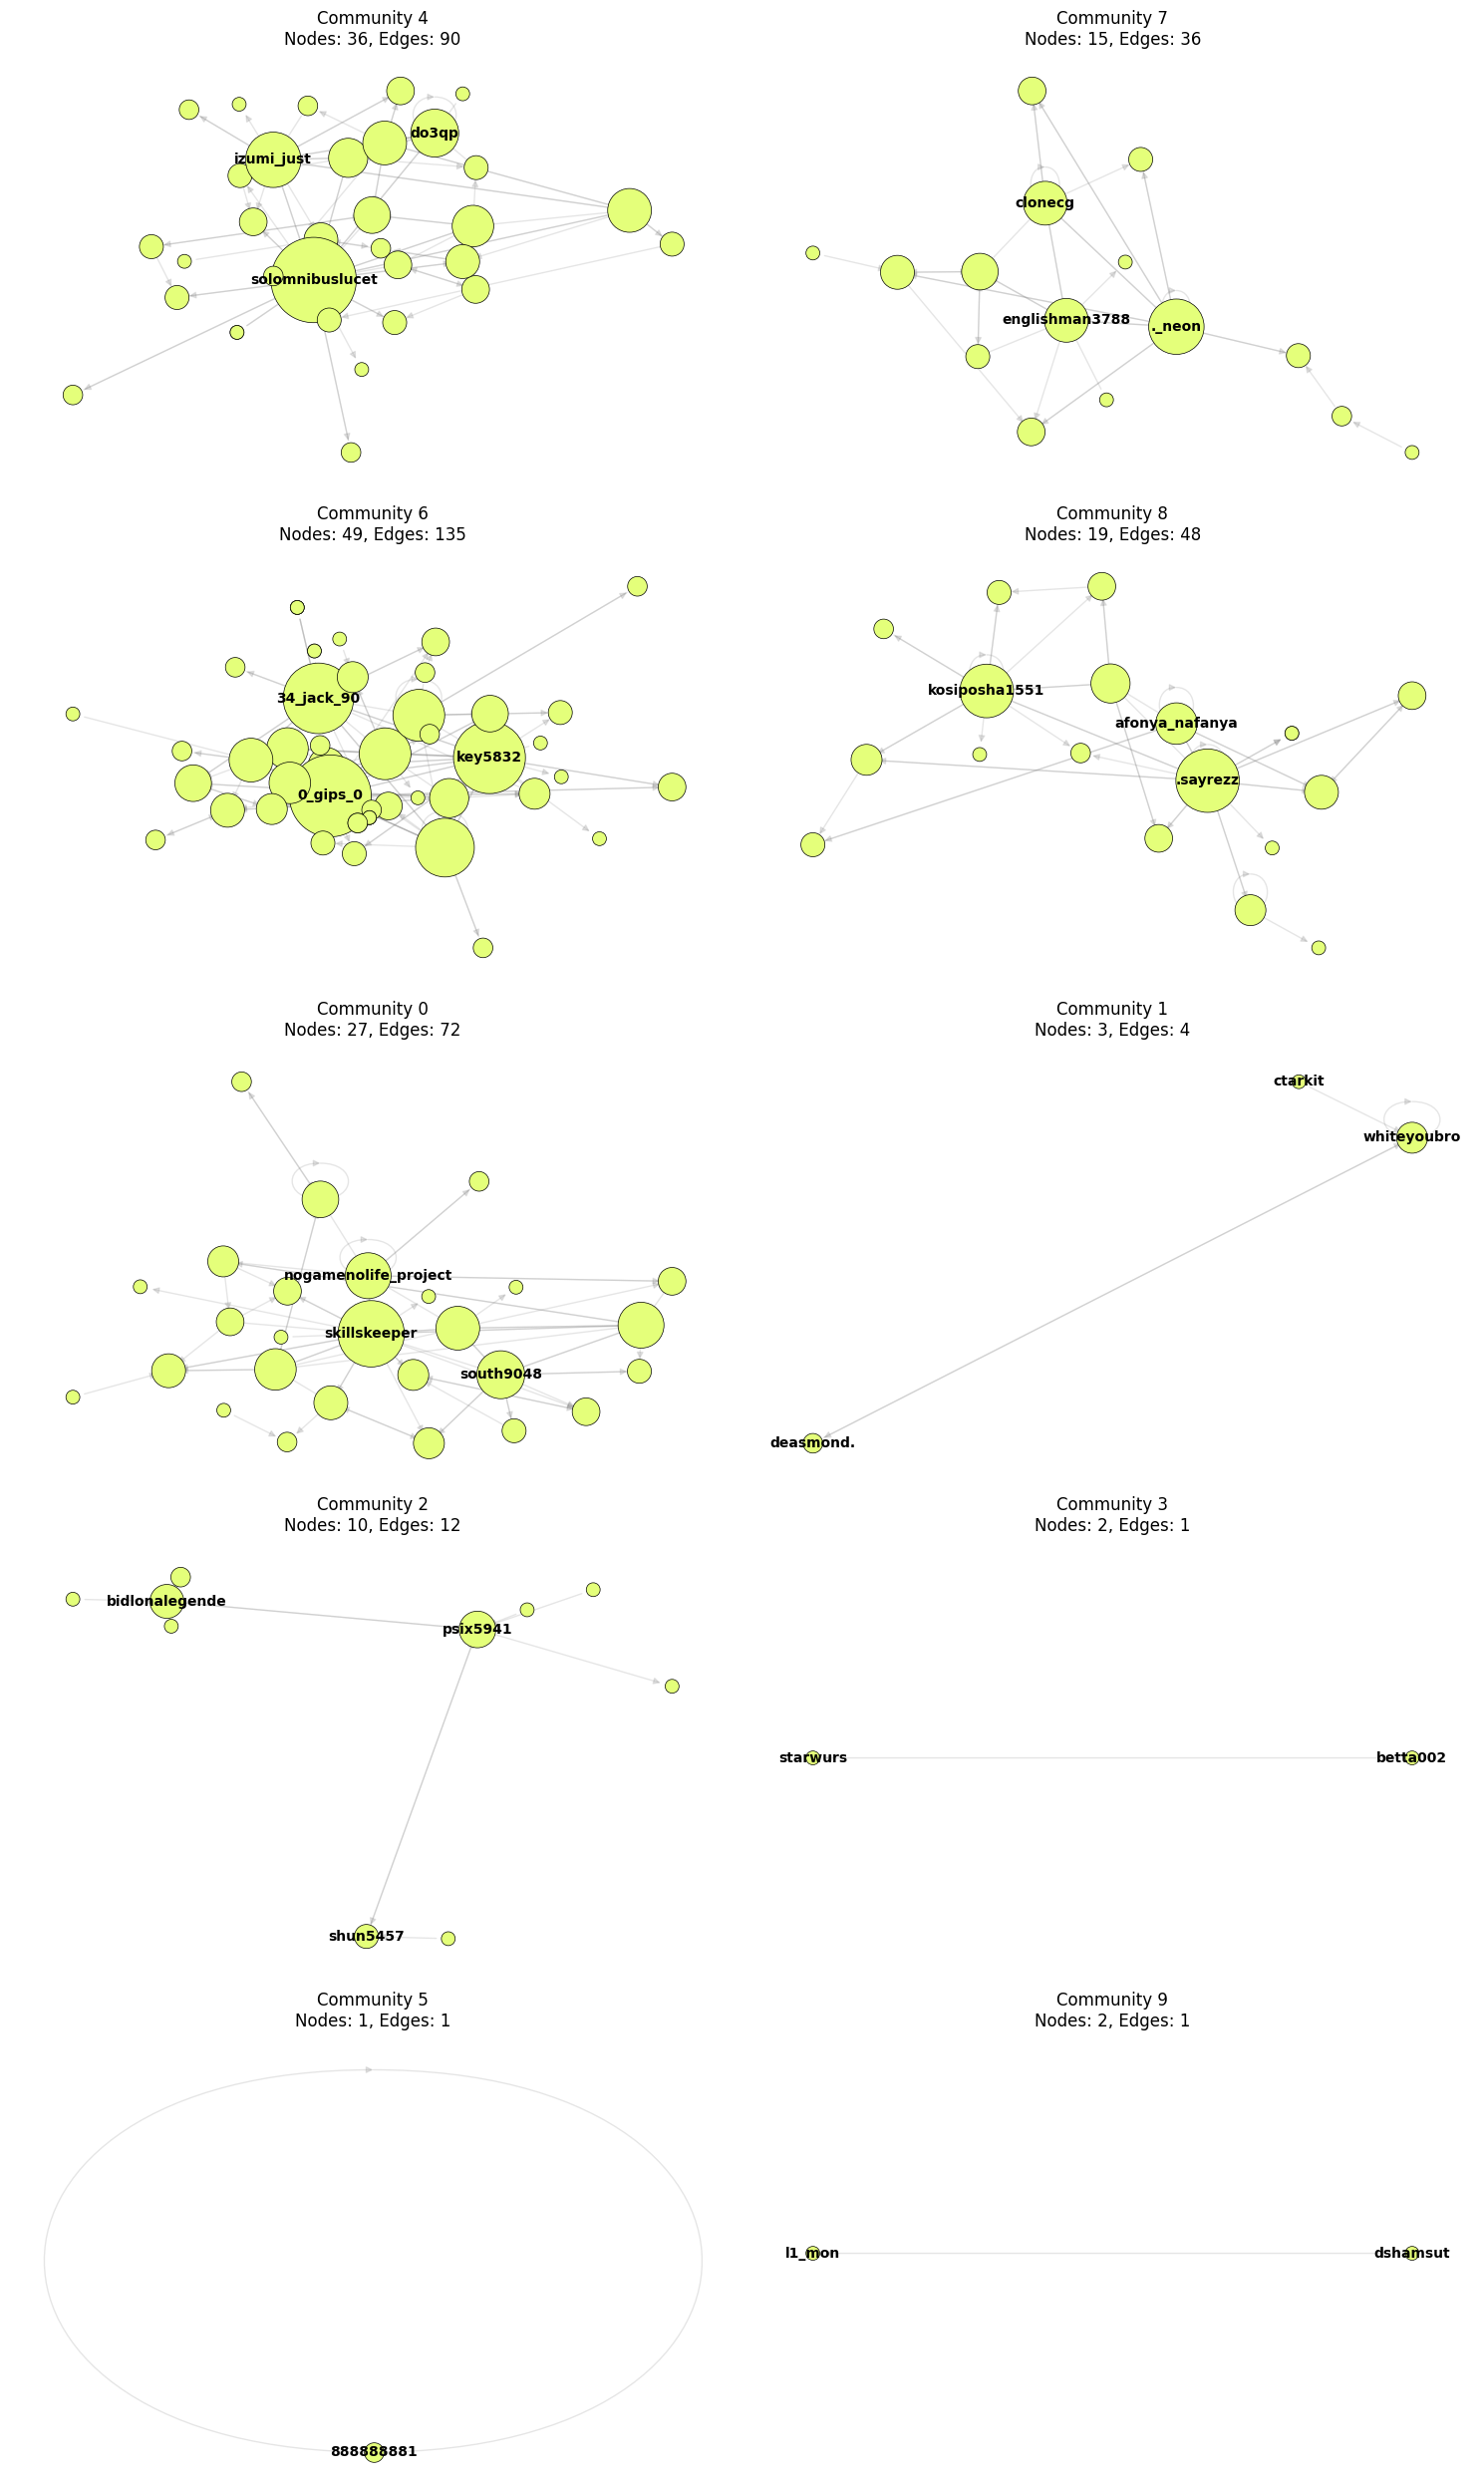

In [34]:
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)
target_communities = {k: v for k, v in communities.items()}
num_plots = len(target_communities)

cols = 2
rows = (num_plots + 1) // cols
plt.figure(figsize=(15, 5 * rows))

for i, (comm_id, nodes) in enumerate(target_communities.items()):
    plt.subplot(rows, cols, i + 1)

    subgraph = G.subgraph(nodes)

    pos_sub = nx.kamada_kawai_layout(subgraph)

    nx.draw_networkx_edges(subgraph, pos_sub, alpha=0.2, edge_color='gray')

    node_sizes = [v * 100 for v in dict(subgraph.degree()).values()]
    nx.draw_networkx_nodes(
        subgraph, pos_sub,
        node_size=node_sizes,
        node_color=[partition[n] for n in subgraph.nodes()],
        cmap=plt.cm.Wistia,
        edgecolors='black',
        linewidths=0.5
    )

    # топ-3 самых активных в этом кластере
    top_in_comm = sorted(dict(subgraph.degree()).items(), key=lambda x: x[1], reverse=True)[:3]
    labels_louvain = {n: G.nodes[n].get('name', n).split('#')[0] for n, d in top_in_comm}
    nx.draw_networkx_labels(subgraph, pos_sub, labels=labels_louvain, font_size=10, font_weight='bold')

    plt.title(f"Community {comm_id}\nNodes: {len(nodes)}, Edges: {subgraph.number_of_edges()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

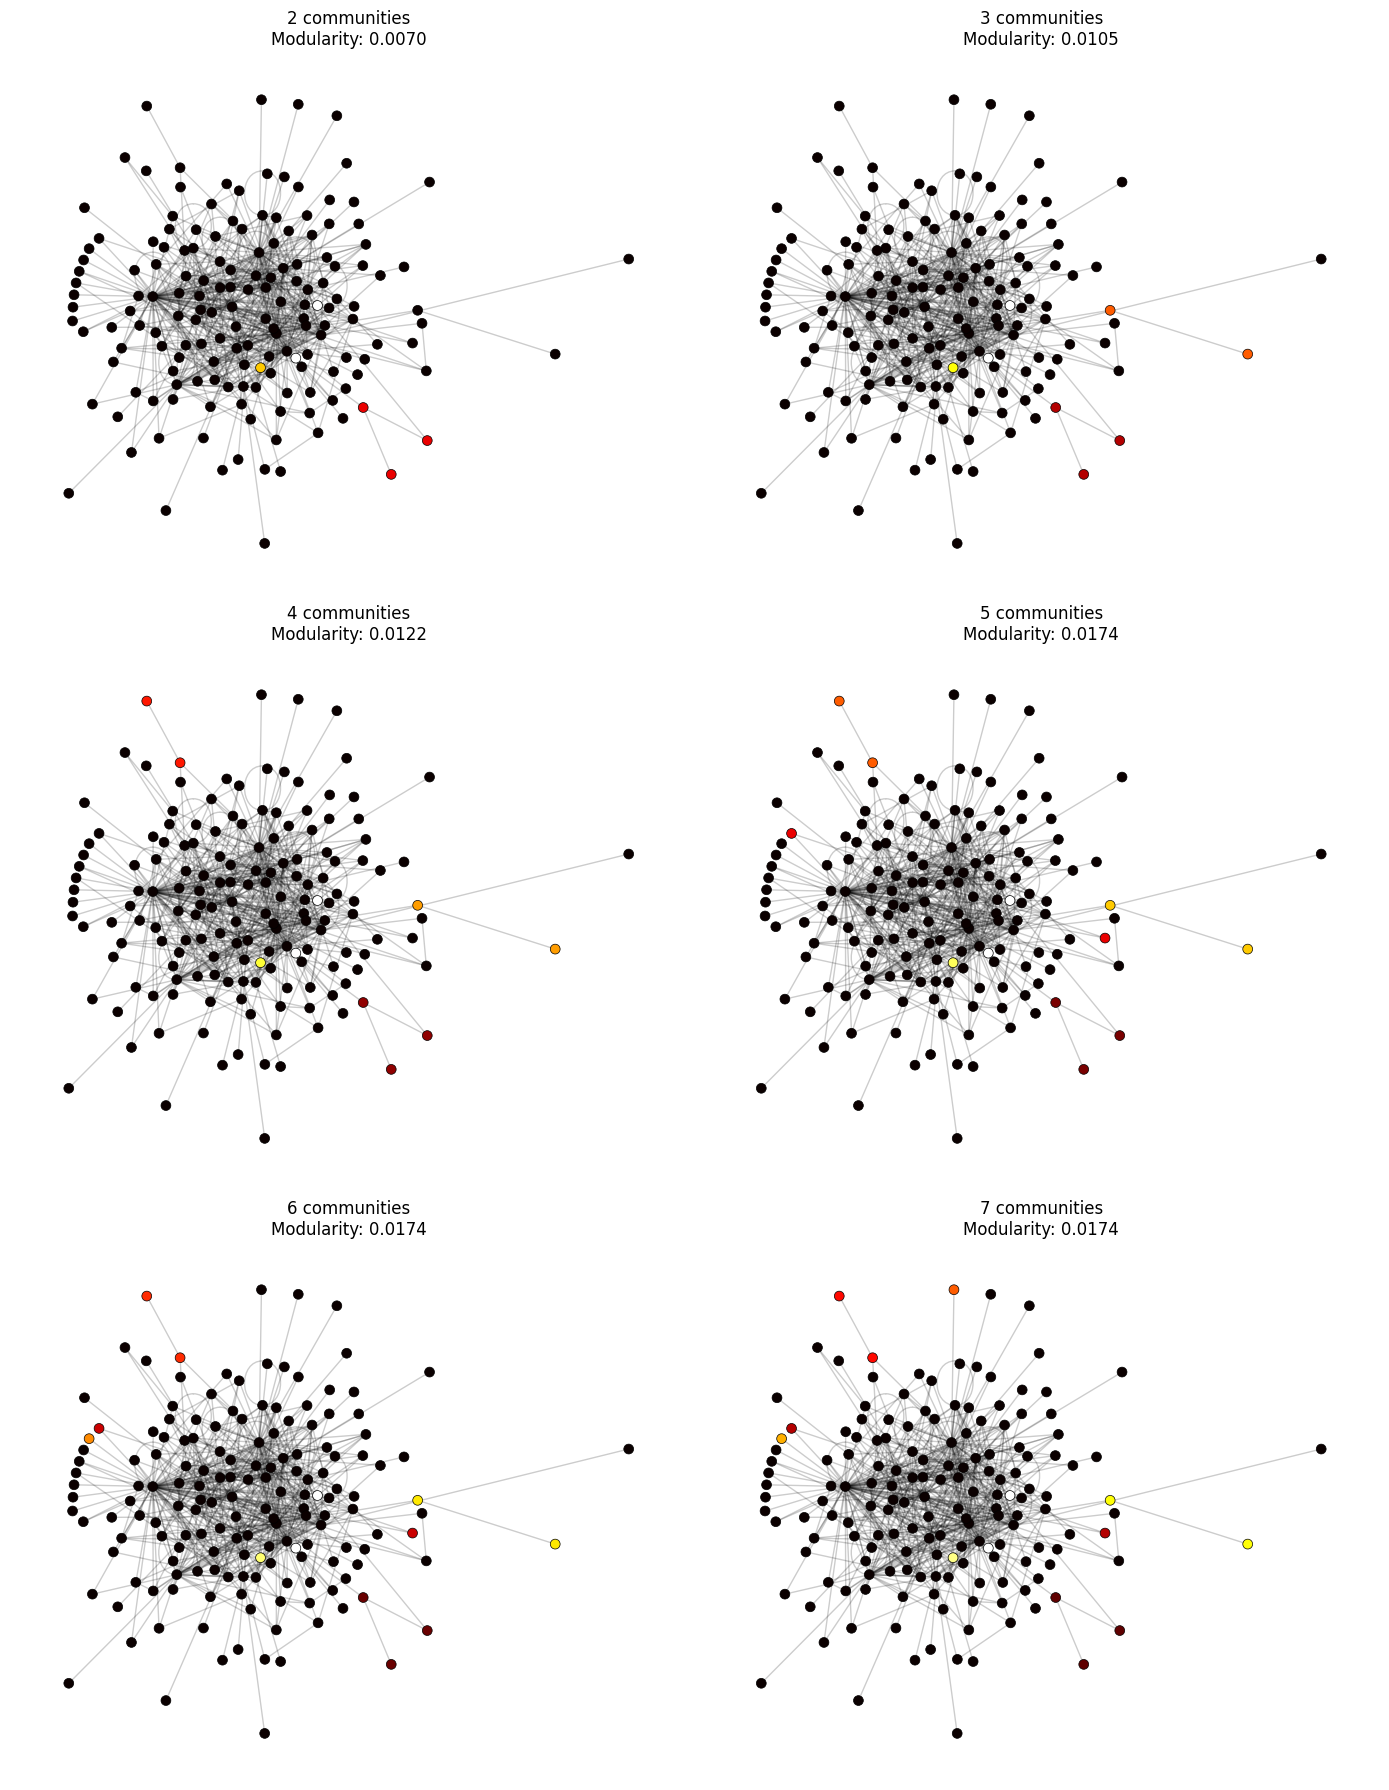

In [27]:
U = G.to_undirected()
pos_gn = nx.kamada_kawai_layout(U)
comp = community.girvan_newman(U)

labels_gn = []
modularities = []
steps = 6

for i in range(steps):
    communities = next(comp)
    node_to_comm = {}
    for cluster_id, nodes in enumerate(communities):
        for node in nodes:
            node_to_comm[node] = cluster_id

    labels_gn.append([node_to_comm[node] for node in U.nodes()])
    modularities.append(nx_comm.modularity(U, communities))

plt.figure(figsize=(14, 18))
for i in range(steps):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        U, pos_gn,
        cmap=plt.cm.hot,
        node_color=labels_gn[i],
        node_size=50,
        edgecolors='black',
        linewidths=0.5
    )
    nx.draw_networkx_edges(U, pos_gn, alpha=0.2)
    plt.title(f'{i+2} communities\nModularity: {modularities[i]:.4f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
best_step_idx = np.argmax(modularities)
best_gn_labels = labels_gn[best_step_idx]
print(f"Best GN Step: {best_step_idx + 2} communities")
print(f"Best GN Modularity: {modularities[best_step_idx]:.4f}")

Best GN Step: 5 communities
Best GN Modularity: 0.0174


Алгоритм Louvain показал значительно более высокий результат ($Q = 0.3281$). В сетевом анализе значения модулярности выше 0.3 считаются признаком того, что в сети есть реальная, неслучайная структура сообществ. Это подтверждает, что пользователи в сети склонны объединяться в устойчивые группы.

Тот факт, что коэффициент кластеризации (0.3395) почти равен модулярности Louvain (0.3281), говорит о том, что сообщества в сети формируются очень органично: люди, которые общаются с общими друзьями.

Алгоритм Girvan-Newman подтверждает наличие доминирующего центрального компонента. Низкая модулярность при иерархическом делении указывает на то, что связи между ключевыми участниками (такими как solomnibuslucet и 34_jack_90) слишком плотные, чтобы их можно было легко разделить на независимые подгруппы без потери связности.

Распределение степеней узлов показывает, что большинство пользователей имеют менее 10 связей, в то время как лидеры («хабы») — более 50. Именно эти хабы (например, solomnibuslucet) связывают сообщества Louvain между собой, не давая алгоритму Girvan-Newman эффективно их разделить.

In [29]:
U_no_self = U.copy()
U_no_self.remove_edges_from(nx.selfloop_edges(U_no_self))
core_numbers = nx.core_number(U_no_self)

max_k = max(core_numbers.values())

main_core_nodes = [node for node, k in core_numbers.items() if k == max_k]

print(f"Максимальный порядок ядра (Max K-core): {max_k}")
print(f"Количество узлов в главном ядре: {len(main_core_nodes)}")

Максимальный порядок ядра (Max K-core): 8
Количество узлов в главном ядре: 31


Анализ связности с помощью K-core декомпозиции показал, что сеть обладает устойчивым ядром 8-го порядка, состоящим из 31 узла.

Наличие такой многочисленной группы (около 20% от общего числа активных узлов), где каждый участник связан как минимум с 8 другими членами ядра, свидетельствует о высокой социальной зрелости сообщества. Это "социальный капитал" сервера: даже при потере нескольких активных участников, ядро сохранит свою целостность и продолжит функционировать. Данная группа из 31 человека является основным драйвером коммуникации и обеспечивает структурную стабильность всего графа

In [33]:
nodes_order = list(U.nodes())
louvain_list_for_nmi = [partition[node] for node in nodes_order]
nmi_value = normalized_mutual_info_score(louvain_list_for_nmi, best_gn_labels)

print(f"NMI (Louvain vs Best GN): {nmi_value:.4f}")

NMI (Louvain vs Best GN): 0.2271


Значение NMI = 0.1731 указывает на существенное различие в логике работы алгоритмов на данных Discord.

*   Алгоритм Louvain показал значительно более высокую модулярность (0.3281), что свидетельствует о его способности выделять плотные тематические сообщества.

*   Алгоритм Girvan-Newman продемонстрировал низкую сходимость с Louvain, так как в условиях высокой плотности связей в центре графа он фокусируется на удалении мостов (bridges) на периферии, не обеспечивая качественной сегментации основного ядра участников.

Таким образом, для анализа данного сообщества алгоритм Louvain является более релевантным, а низкий NMI подтверждает иерархическую и централизованную структуру сети, которую сложно разбить на однозначные блоки